In [305]:

%load_ext autoreload
%autoreload 2

import sys
import os
import json
import pandas as pd
import MDAnalysis as mda
from utils import utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sbmlcore
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

from scipy.stats import ttest_ind


from PIL import Image



sys.path.append(os.path.abspath('ml-models'))
from mlmodels.Models import Models


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Import

### Isolate dataset (ie all matched solos)

Import solo mutations in rpoB - these are the isolates from which the ML dataframe is generated

In [306]:
solos = pd.read_csv('./data/tables/generated/rpoB_solos.csv')
solos

,UNIQUEID,GENE,MUTATION,POSITION,AMINO_ACID_NUMBER,GENOME_INDEX,NUCLEOTIDE_NUMBER,REF,ALT,IS_SNP,...,ELEMENT_TYPE,MUTATION_TYPE,INDEL_LENGTH,INDEL_1,INDEL_2,SITEID,NUMBER_NUCLEOTIDE_CHANGES,segid,resid,PHENOTYPE
0,site.02.subj.1033.lab.2013185075.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,450,R
1,site.02.subj.0739.lab.2013221518.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,450,R
2,site.02.subj.0604.lab.241032-14.iso.1,rpoB,M587I,587.0,587.0,NaN,NaN,atg,ata,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,587,S
3,site.02.subj.0104.lab.22A057.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,450,R
4,site.02.subj.0885.lab.22A119.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,02,1,C,450,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9833,site.10.subj.SATRL0116187_S19.lab.TRL0116187_S...,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,10,1,C,450,R
9834,site.10.subj.SATRL0117008_S16.lab.TRL0117008_S...,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,10,1,C,450,R
9835,site.10.subj.SATRL0115669_S18.lab.TRL0115669_S...,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,10,1,C,450,R
9836,site.10.subj.XD01227882.lab.XD01227882.iso.1,rpoB,S450L,450.0,450.0,NaN,NaN,tcg,ttg,True,...,GENE,AAM,NaN,NaN,NaN,10,1,C,450,R


### ML dataset

The dataset used to train (and test) the models contains unique mutations - the mutation counts in the solo isolate df above is used to determine phenotypes for each mutation.

In [307]:
data = pd.read_csv('./data/tables/generated/features_dataset.csv', index_col=0)

#replace R/S labels with binary 1/0
data['phenotype'] = [1 if i =='R' else 0 for i in data.PHENOTYPE]
#remove dynamic features generated from md simulations - will explore later
data = data.drop(columns=[col for col in data.columns if 'min' in col or 'mean' in col])

data

,segid,mutation,PHENOTYPE,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,Mg_distance,...,psi,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,deep_ddG,rasp_score,temp_factor,secondary_structure,phenotype
0,C,A1002P,S,24.1,-3.4,26.0,0.30,0.020,45.415055,31.783345,...,164.84,1.0,1.0,7.268116,36,-2.927,0.800033,36.009998,0,0
1,C,A286V,R,51.4,2.4,28.0,-0.04,0.232,47.831892,64.028439,...,-17.70,0.0,1.0,0.000000,-31,-0.523,0.222401,121.500000,1,1
2,C,A29T,S,27.5,-2.5,30.0,-0.40,0.248,34.306893,40.030977,...,161.38,0.0,0.0,34.753706,-81,-1.142,0.328659,32.820000,2,0
3,C,A29V,S,51.4,2.4,28.0,-0.04,0.232,34.306893,40.030977,...,161.38,0.0,0.0,34.753706,-76,-1.056,0.284229,32.820000,2,0
4,C,A334D,S,22.5,-5.3,44.0,-3.23,0.029,43.228183,56.772771,...,-16.26,1.0,1.0,0.786252,-54,-2.734,0.369132,102.089996,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,C,V895F,S,49.9,-1.4,48.1,-0.48,0.345,41.296670,28.986757,...,-22.89,0.0,0.0,35.841417,-1,-1.014,0.287163,37.750000,3,0
302,C,V946G,S,-79.9,-4.6,-42.0,0.01,-0.080,53.471656,48.889279,...,122.58,0.0,0.0,86.193134,-81,-0.444,0.424508,68.440002,2,0
303,C,Y308C,R,-85.1,3.8,-60.0,-0.59,-0.199,33.128330,49.415429,...,-35.81,1.0,1.0,70.874065,68,-1.361,0.467171,76.190002,1,1
304,C,Y572C,S,-85.1,3.8,-60.0,-0.59,-0.199,37.911061,45.458752,...,172.92,1.0,1.0,27.871431,35,-1.543,0.563006,61.090000,0,0


# Some Features are more predictive than others

To get an idea of how powerful each feature is, we can generate a logisitic regression for each isolated feature in turn and measure model performance. 

In [308]:
outputs= {}
feature_list = data.columns[3:-1]
#iterate through features and train a model on that feature alone
for feat in feature_list:
    outputs[feat] =  Models({feat:data[[feat, 'phenotype']]}, 
                      "LR", "average_precision", random_seed=11, test_fraction=0.25, verbose=False, output_plots=False).returning_output(output_plots=False)

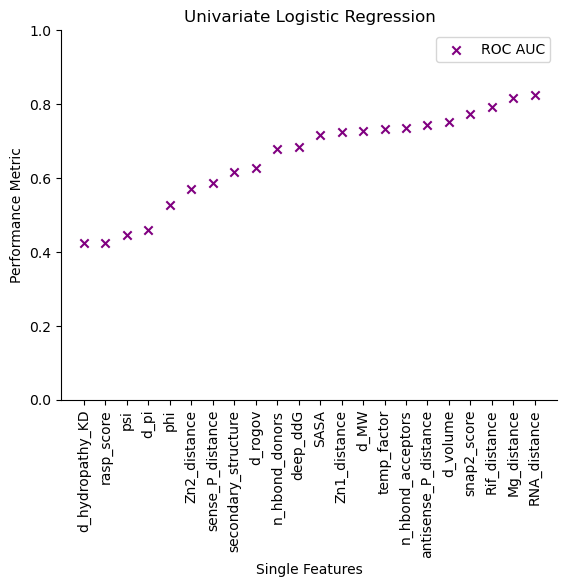

In [309]:
#plot roc_auc values for each feature's model

roc_auc = []
for key in outputs:
    key_dict = dict(outputs[key].items())
    roc_auc.append(key_dict["ROC_AUC"])

# Sort features and roc_auc values
sorted_features_roc_auc = sorted(zip(feature_list, roc_auc), key=lambda x: x[1])
sorted_feature_list, sorted_roc_auc = zip(*sorted_features_roc_auc)

# Feature order is from roc_auc from quick univariate LR in notebook 3
fig, ax = plt.subplots()
ax.scatter(sorted_feature_list, sorted_roc_auc, marker='x', label='ROC AUC', color='purple')
ax.set_xlabel('Single Features')
ax.set_ylabel('Performance Metric')
plt.xticks(rotation=90)
ax.legend() 
plt.ylim(0, 1)
ax.set_title("Univariate Logistic Regression")
sns.despine(ax=ax, top=True, right=True)

plt.savefig('./imgs/univariate_LR_metrics.png', bbox_inches='tight', dpi=600, format='png')

The most predictive feature is SNAP_2  score - this isn't surprising given SNAP2 uses a neural net trained on evolutional infromation sand strucutral features(like solvent accessibility) to predict changes to secondary structure on mutation. 

Following SNAP_2, the most predictive features are distance-based metrics. This is also unsurprising as rifampicin RAVs are typically located within the RRDR, a very well defined region in rpoB that constitutes resiudes involved in rifapicin binding:


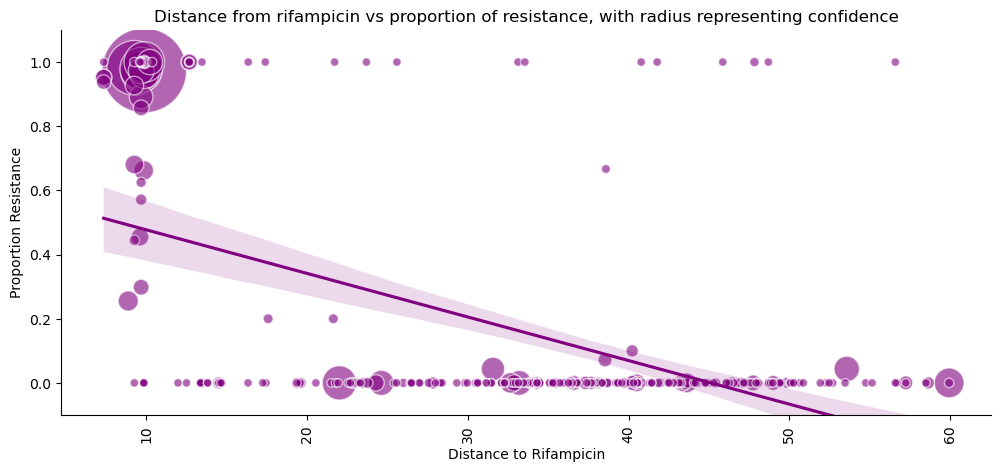

In [310]:
#cross tab our solos dataframe to get phenotype counts for each unique mutation
ct = pd.crosstab([solos.MUTATION, solos.segid, solos.resid], solos.PHENOTYPE)
ct["total"] = ct.sum(axis=1)
ct.sort_values(by='total', inplace=True, ascending=False)
ct[['proportion_R', 'ci_lower', 'ci_upper']] = ct.apply(lambda row: utils.wilson(row['R'], row['total']), axis=1, result_type='expand')
ct = ct.reset_index().rename(columns={'MUTATION':'mutation'})

# Merging ct with ML dataframe to pull out distances to rifampicin for each mutation
ct_features = pd.merge(ct, data, on=['mutation'], how='inner')
ct_features['ci_width'] = ct_features['ci_upper'] - ct_features['ci_lower']
ct_features['marker_size'] = (1 / ct_features['ci_width']) * 30  # Scale for visibility

#plot distance to rifampicin vs proportion resistance, with some measure of confidence (ie sample size) in the proportion 
fig, ax = plt.subplots(figsize=(12, 5))
sc = ax.scatter(ct_features['Rif_distance'], ct_features['proportion_R'], 
                s=ct_features['marker_size'], c='purple', alpha=0.6, edgecolors='w', label='Data points')
sns.regplot(x='Rif_distance', y='proportion_R', data=ct_features, scatter=False, color='purple', ax=ax)
ax.set_xlabel('Distance to Rifampicin')
ax.set_ylabel('Proportion Resistance')
plt.xticks(rotation=90)
plt.ylim(-0.1, 1.1)
sns.despine(ax=ax, top=True, right=True)
norm = plt.Normalize(ct_features['ci_width'].min(), ct_features['ci_width'].max())
sm = plt.cm.ScalarMappable(cmap="Purples", norm=norm)
sm.set_array([])
plt.title('Distance from rifampicin vs proportion of resistance, with radius representing confidence')
plt.savefig('./imgs/distance_vs_probR_confidence.png', bbox_inches='tight', dpi=600, format='png')
plt.show()

 Via relative positioning, distance based metrics thus allow the model to idenitify mutations that are within the RRDR and are likely to induce resistance (ie the lower the distance to rifampicin or mRNA, the greater the probability that mutation confers resistance).


RASP score, psi angles, changes in hydropathy, and changes in sioeelctirc point also return ROC AUC socres less than 0.5 - these are therefore dropped from the analysis.

In [311]:
data = data.drop(columns=['d_hydropathy_KD', 'psi', 'rasp_score', 'd_pi'])
feature_list = data.columns[3:-1]
print ('Number of features left in our data:', len(feature_list))

Number of features left in our data: 18


# Machine learning models trained on all features are predictive 

If we just use a naive approach and include all remaining features, the models perform well.

Following the manuscript, we can split our data, tune the model on the training set, and then boostrap the validation set to get confidence.

In [312]:
models = ['LR', 'RF', 'DT', 'GBDT']
feature_set = data.columns[3:-1]
outputs = {}

for model_type in models:
    feature_data = data[feature_set].copy()
    feature_data["phenotype"] = data["phenotype"]

    model_obj = Models(
        {"all": feature_data},
        model_type,
        "average_precision",
        random_seed=0,
        test_fraction=0.25,
        verbose=False,
        output_plots=False,
    )

    model = model_obj.opt_estimator
    X_test = model_obj.X_test_nd["all"]
    y_test = model_obj.y_test_nd["all"]
    threshold = model_obj.opt_threshold

    print (model)
    outputs[model_type] = utils.manual_bootstrap(model, X_test, y_test,threshold=threshold, n_iterations=100)
     


Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=1, max_iter=10000))])
RandomForestClassifier(max_depth=4, n_jobs=-1, random_state=0)
DecisionTreeClassifier(max_depth=2, random_state=0)
GradientBoostingClassifier(max_depth=2, n_estimators=20, random_state=0)


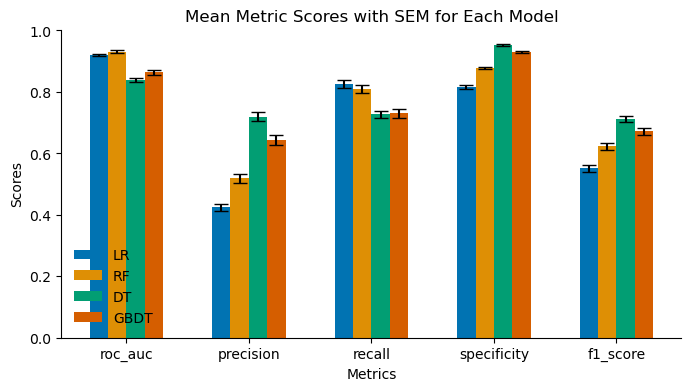

In [313]:

# Calculate mean and standard deviation for each metric
mean_metrics = {}
std_metrics = {}

for model_type, metrics in outputs.items():
    mean_metrics[model_type] = {metric: np.mean(values) for metric, values in metrics.items()}
    std_metrics[model_type] = {metric: (np.std(values, ddof=1) / np.sqrt(len(values))) for metric, values in metrics.items()}

# Metrics to plot
metric_names = ['roc_auc', 'precision', 'recall', 'specificity', 'f1_score']
model_names = list(mean_metrics.keys())
n_models = len(model_names)
n_metrics = len(metric_names)

# Positioning the bars
bar_width = 0.15
index = np.arange(n_metrics)

# Set color palette
colors = sns.color_palette("colorblind", n_models)

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 4))

for i, model in enumerate(model_names):
    means = [mean_metrics[model][metric] for metric in metric_names]
    stds = [std_metrics[model][metric] for metric in metric_names]
    ax.bar(index + i * bar_width, means, bar_width, yerr=stds, capsize=5, label=model, color=colors[i])

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Mean Metric Scores with SEM for Each Model')
ax.set_xticks(index + bar_width * (n_models - 1) / 2)
ax.set_xticklabels(metric_names)

# Style the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False)

# Show the plot
plt.show()


The first thing I notice is this performance is much lower than the manuscript. This is concerning, as we have both bootstrapped our validation set 100 times...so where is this coming from? If we just think about it logically: 

- The specific hyperparameter tuning of models is somewhat irrelevant as we know these models are v stable - so even if ml-models decided on different optimal parameters for some reason, it shouldn't matter
- Our entire feature datasets are identical

Therefore the only thing left that differs is our training and validation sets due to differing splits (seed doesn't matter as the dataframes have different orders).

Differing performanmce on splits is not uncommon when there is little data, or there is a strong imbalance in pos/negs, both of which are scenarios we are dealing with:

In [314]:
data.PHENOTYPE.value_counts()

PHENOTYPE
S    256
R     50
Name: count, dtype: int64

We will struggle to get stable performance across different seeds - if we simply run 2 LR models using different random seeds, performance is very different:

In [315]:
feature_set = data.columns[3:]
feature_data = data[feature_set]

q = Models(
        {"all": feature_data},
        'LR',
        "average_precision",
        random_seed=0,
        test_fraction=0.25,
        verbose=False,
        output_plots=False,
    ).returning_output(output_plots=False)

print ('precision', q['Precision_shifted'])
print ('sensivitity', q['Sensitivity_shifted'])
print ('specificity', q['Specificity_shifted'])


precision 0.42857142857142855
sensivitity 0.8181818181818182
specificity 0.8181818181818182


In [316]:
q = Models(
        {"all": feature_data},
        'LR',
        "average_precision",
        random_seed=5,
        test_fraction=0.25,
        verbose=False,
        output_plots=False,
    ).returning_output(output_plots=False)

print ('precision', q['Precision_shifted'])
print ('sensivitity', q['Sensitivity_shifted'])
print ('specificity', q['Specificity_shifted'])

precision 0.8
sensivitity 0.47058823529411764
specificity 0.9666666666666667


This is crazy - performance on a single validation set which was arbitrarily generated is meangingless if the seed is non-trivial - changing the random seed for the bootsrapped plot above also given very different values.

Also, Charlotte has not plotted the mean of bootstrapping, but rather the performance achieved on the entire validation set with the sem bars from the bootsrapping overlaid - this is not right and leads to an overestimate.

The mean sensitivity of the boots will not average to the sensitivity on the whole set when there are so few resistant mutations - each boot could perform very differently and clearly some mutations are poorly predictive.

We can even see from the original codebase that the bootstrapped performance is ghastly:



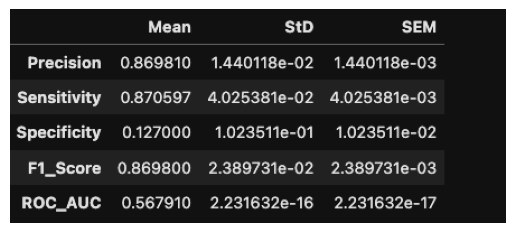

In [317]:
image = Image.open('./Screenshot 2024-07-20 at 19.37.28.png')

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

This is really bad - those are the means that should have bee plotted (as those are the sems that were used).... 

A specificty of 12% is bizarre - wouldn't expect that at all with this dataset...

So there are already 2 big flaws with the analysis...


We should measure validation set performance across a bunch of splits, and then try to stabilise it - if the model is this dataset dependent (and they all are, irrespective of architecture) then its pretty much useless.

In [318]:
#use ml-models to determine best model and decision threshold, on most data - gives us something to work with
model = Models(
        {"all": feature_data},
        'LR',
        "average_precision",
        random_seed=0,
        test_fraction=0.05,
        verbose=False,
        output_plots=False,
    )

est = model.opt_estimator
thresh = model.opt_threshold

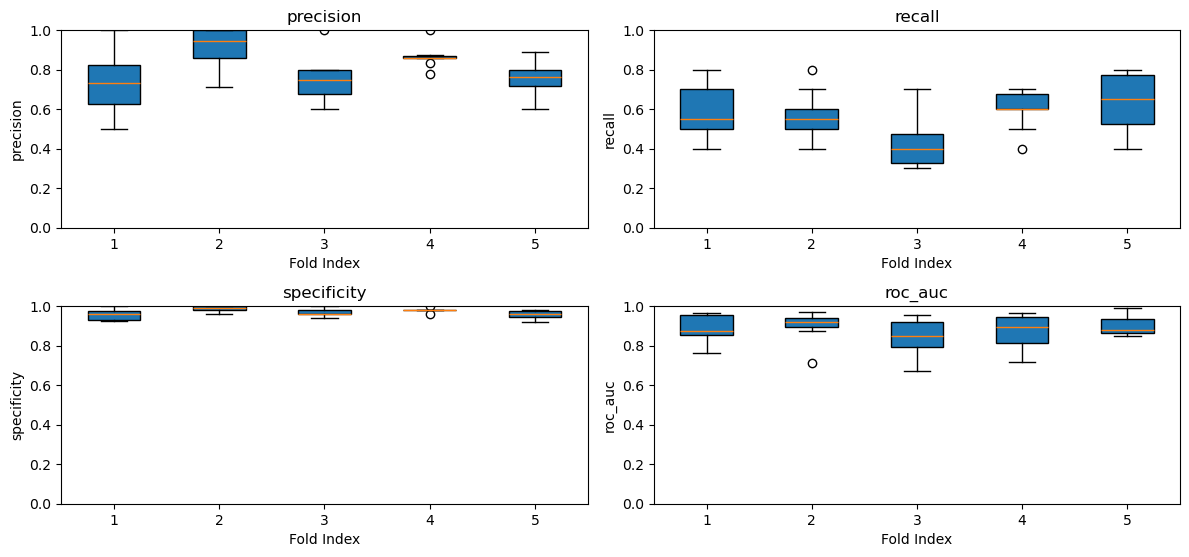

In [319]:
X = feature_data.drop(columns=['phenotype'])
y = feature_data['phenotype']

metrics = utils.repeated_kfold_evaluation(est, X, y, threshold=thresh, n_splits=5, n_repeats=10)

# Plot the results
plt.figure(figsize=(12, 8))

num_metrics = len(metrics)
for idx, metric in enumerate(metrics):
    plt.subplot(3, 2, idx+1)
    plt.boxplot(metrics[metric], notch=False, patch_artist=True)
    plt.title(metric)
    plt.xlabel('Fold Index')
    plt.ylim(0, 1)
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

Not only is our mean sensitivity across folds low, but it is also high variable. Depending on how the data is spit - we can see this within folds and across folds. 

Specificy and roc-auc are high and relativel stable.

Therefore, depending on how the data is split, we get low and variable ability to detect hits, but we do well at detecting negatives. This aligns with the hypothesis that we do not have enough resistant samples.

Note, this is also using an 'optimal decision threshold' which is very low (0.2) - this reflect the 0.5 R/S classification data prep step, which should really be around 0.1 (rpoB has very high penetrance).

For now, let's get back go to the manuscript, we can try and stabilise after.

# Removing features does not reduce predictive power

We can use the feature rankings generated from the ROC AUC values from the logisitic regression model above to sequentlly remove features and determine performance.

Presently this is flawed as the ROC AUC values for each feature are dependent on the data split, so the order of removal is meaningless.

In [320]:
feature_set = [i for i in sorted_feature_list  if i in feature_list]

print ('The order in which we will remove features', feature_set)

#export order so can do other models in the supplement
with open('./data/temp/sorted_features.json', 'w') as f:
    json.dump(feature_set, f)

The order in which we will remove features ['phi', 'Zn2_distance', 'sense_P_distance', 'secondary_structure', 'd_rogov', 'n_hbond_donors', 'deep_ddG', 'SASA', 'Zn1_distance', 'd_MW', 'temp_factor', 'n_hbond_acceptors', 'antisense_P_distance', 'd_volume', 'snap2_score', 'Rif_distance', 'Mg_distance', 'RNA_distance']


In [321]:
columns = feature_set + ['phenotype']
outputs = {}

for feat in feature_set[:-1]:
    feature_data = data[columns]
    outputs[len(columns)-1] = Models(
            {"all": feature_data},
            'LR',
            "average_precision",
            random_seed=0,
            test_fraction=0.25,
            verbose=False,
            output_plots=False,
        ).returning_output(output_plots=False)
    columns.remove(feat)



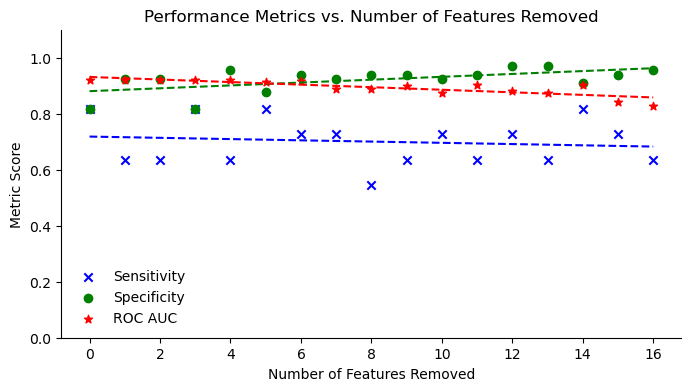

In [322]:
utils.plot_backwards_elim(outputs, figsize=(8, 4))

We don't see much change as features are removed - therefore, a single based feature is sufficient for predictive power.

Let's see if the most importance features are required for predictive power - we will remove in the opposite order, leaving the most unimportant features:

In [323]:
rev_feature_set = feature_set[::-1]
print ('The order in which we will remove features', rev_feature_set)

The order in which we will remove features ['RNA_distance', 'Mg_distance', 'Rif_distance', 'snap2_score', 'd_volume', 'antisense_P_distance', 'n_hbond_acceptors', 'temp_factor', 'd_MW', 'Zn1_distance', 'SASA', 'deep_ddG', 'n_hbond_donors', 'd_rogov', 'secondary_structure', 'sense_P_distance', 'Zn2_distance', 'phi']


In [324]:
columns = rev_feature_set + ['phenotype']
outputs = {}

for feat in rev_feature_set[:-1]:
    feature_data = data[columns]
    outputs[len(columns)-1] = Models(
            {"all": feature_data},
            'LR',
            "average_precision",
            random_seed=0,
            test_fraction=0.25,
            verbose=False,
            output_plots=False,
        ).returning_output(output_plots=False)
    columns.remove(feat)



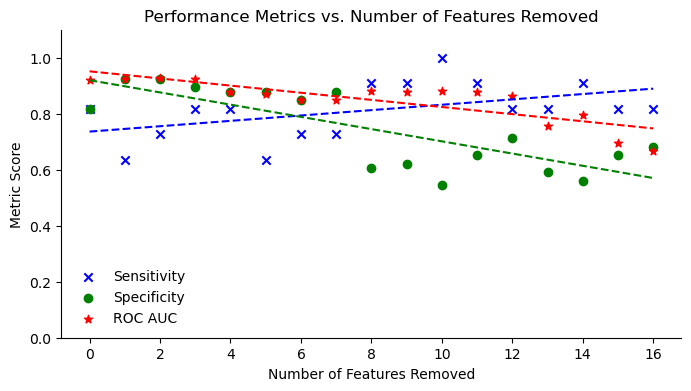

In [325]:
utils.plot_backwards_elim(outputs, figsize=(8, 4))

Our specificity (and accordingly out ROC AUC values) degrade as the most important features are removed.

In theory the model doesn't only need a distance to elements near the rif binding site, as distances to any other 2 points provides triangulation. What happens when we remove distances altogether (lets remove snap2 as well as its so powerful)?


In [326]:
feature_set_no_dist = [i for i in feature_set if (not "distance" in i) and (not "snap2_score" in i)]
feature_set_only_dist = [i for i in feature_set if ("distance" in i) or ("snap2_score" in i)]

# Function to generate outputs
def generate_outputs(feature_set, data):
    columns = feature_set + ['phenotype']
    outputs = {}
    for feat in feature_set[:-1]:
        feature_data = data[columns]
        outputs[len(columns)] = Models(
            {"all": feature_data},
            'LR',
            "average_precision",
            random_seed=0,
            test_fraction=0.25,
            verbose=False,
            output_plots=False,
        ).returning_output(output_plots=False)
        columns.remove(feat)

    return outputs

# Generate outputs dictionaries
outputs1 = generate_outputs(feature_set_only_dist, data)
outputs2 = generate_outputs(feature_set_no_dist, data)

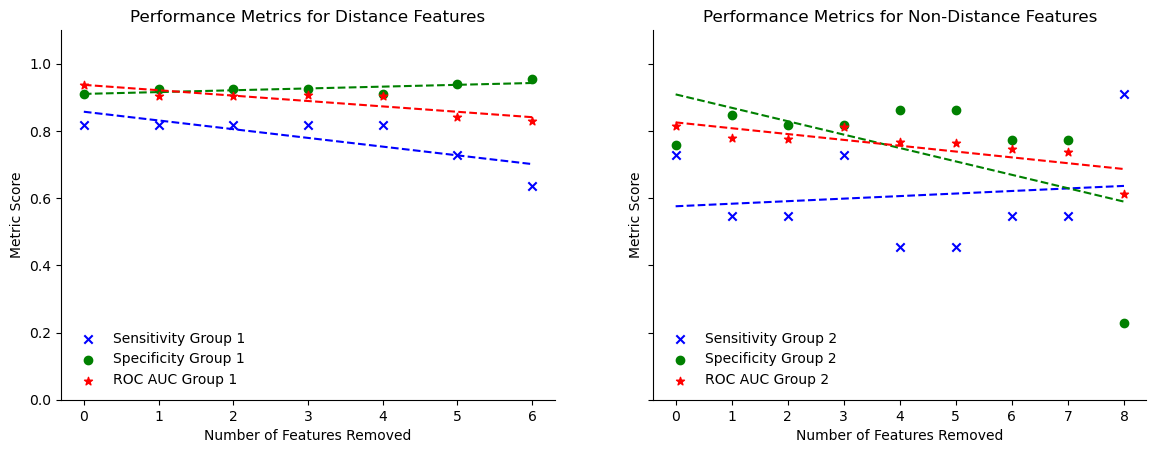

In [327]:
utils.plot_backwards_elim_2_plots(outputs1, outputs2, figsize=(14, 4.8))


In [328]:
def extract_metrics(outputs):
    num_features = sorted(outputs.keys(), reverse=True)
    sensitivity = [outputs[n]['Sensitivity_shifted'] for n in num_features]
    specificity = [outputs[n]['Specificity_shifted'] for n in num_features]
    roc_auc = [outputs[n]['ROC_AUC'] for n in num_features]
    return sensitivity, specificity, roc_auc

sensitivity_distance, specificity_distance, roc_auc_distance = extract_metrics(outputs1)
sensitivity_non_distance, specificity_non_distance, roc_auc_non_distance = extract_metrics(outputs2)

# Perform t-tests for each metric
sensitivity_ttest = ttest_ind(sensitivity_distance, sensitivity_non_distance, equal_var=False)
specificity_ttest = ttest_ind(specificity_distance, specificity_non_distance, equal_var=False)
roc_auc_ttest = ttest_ind(roc_auc_distance, roc_auc_non_distance, equal_var=False)

print("Sensitivity T-Test:", sensitivity_ttest)
print("Specificity T-Test:", specificity_ttest)
print("ROC AUC T-Test:", roc_auc_ttest)

Sensitivity T-Test: TtestResult(statistic=3.034572967243528, pvalue=0.01040924257524296, df=11.96461579903954)
Specificity T-Test: TtestResult(statistic=2.6510791366906465, pvalue=0.02878669837268671, df=8.135085363527566)
ROC AUC T-Test: TtestResult(statistic=5.34133071456953, pvalue=0.00011289679811501421, df=13.669383656174684)


For sensitivity and ROC AUC, there is a statistically significant difference between performance for models that contain any given number of distance related features (including a single feature alone), and the performance of models that contain any number of non-distance related features.


Distances are not necesaary, as the model can perform without them with enough other features. However, distances (even just one) alone are sufficient, regardless of the total number of features - the same can't be said for other features.

Is there any point keeping non-distance features in the model? We can remove non-distance feature sone by one (and keep all distances):

In [329]:
feature_set_no_dist = [i for i in feature_set if (not "distance" in i) and (not "snap2_score" in i)]

columns = feature_set + ['phenotype']
outputs = {}

for feat in feature_set_no_dist:
    feature_data = data[columns]
    outputs[len(columns)-1] = Models(
            {"all": feature_data},
            'LR',
            "average_precision",
            random_seed=0,
            test_fraction=0.25,
            verbose=False,
            output_plots=False,
        ).returning_output(output_plots=False)
    columns.remove(feat)


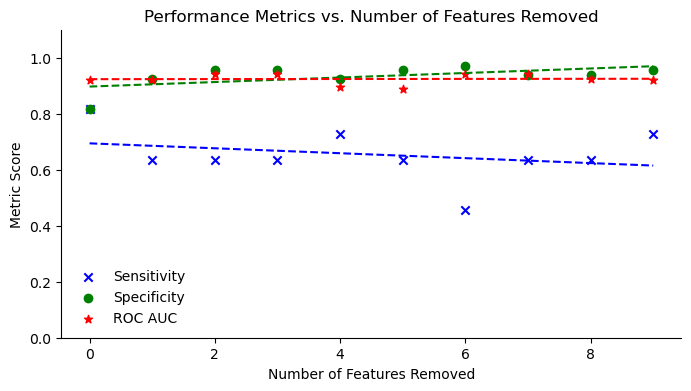

In [330]:
utils.plot_backwards_elim(outputs, figsize=(8, 4))

No real difference between model trained on all features, and only distance based features. Therefore, can include all features or just distances.

# Using dynamical features does not improve performance

If we incorporate data pulled down from MD simulations to give some measure of bond length and angle variability, it could provide the model with information pertaining to structural constraints.

We could also use dynamics to estimate the minimum distance between residues - in theory, this is the distance that matters as the closer the mutated site ot the element of interest, th emore likely it is to have an effect on the phenotype.

We can firslty compare models containing only static distances and angles, to models containing only dynamic minimum distances and angles:

In [362]:
#laod in entire dataset, including dynamic data
data = pd.read_csv('./data/tables/generated/features_dataset.csv', index_col=0)

#replace R/S labels with binary 1/0
data['phenotype'] = [1 if i =='R' else 0 for i in data.PHENOTYPE]

#remove dynamic features generated from md simulations - will explore later
static_data = data.drop(columns=[col for col in data.columns if '_min' in col or 'mean_' in col])
static_data = static_data.iloc[:, 4:]

dynamic_data = data[[col for col in data.columns if '_min' in col or 'mean_' in col or 'phenotype' in col]]

,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,Mg_distance,Zn1_distance,Zn2_distance,antisense_P_distance,...,psi,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,deep_ddG,rasp_score,temp_factor,secondary_structure,phenotype
0,24.1,-3.4,26.0,0.30,0.020,45.415055,31.783345,65.820752,89.775208,57.975782,...,164.84,1.0,1.0,7.268116,36,-2.927,0.800033,36.009998,0,0
1,51.4,2.4,28.0,-0.04,0.232,47.831892,64.028439,75.109206,67.294269,40.591519,...,-17.70,0.0,1.0,0.000000,-31,-0.523,0.222401,121.500000,1,1
2,27.5,-2.5,30.0,-0.40,0.248,34.306893,40.030977,81.478877,81.622597,55.169772,...,161.38,0.0,0.0,34.753706,-81,-1.142,0.328659,32.820000,2,0
3,51.4,2.4,28.0,-0.04,0.232,34.306893,40.030977,81.478877,81.622597,55.169772,...,161.38,0.0,0.0,34.753706,-76,-1.056,0.284229,32.820000,2,0
4,22.5,-5.3,44.0,-3.23,0.029,43.228183,56.772771,74.510909,80.544569,41.085344,...,-16.26,1.0,1.0,0.786252,-54,-2.734,0.369132,102.089996,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,49.9,-1.4,48.1,-0.48,0.345,41.296670,28.986757,64.306366,76.613687,55.614045,...,-22.89,0.0,0.0,35.841417,-1,-1.014,0.287163,37.750000,3,0
302,-79.9,-4.6,-42.0,0.01,-0.080,53.471656,48.889279,84.665675,104.881637,68.230868,...,122.58,0.0,0.0,86.193134,-81,-0.444,0.424508,68.440002,2,0
303,-85.1,3.8,-60.0,-0.59,-0.199,33.128330,49.415429,75.024083,74.776429,38.607935,...,-35.81,1.0,1.0,70.874065,68,-1.361,0.467171,76.190002,1,1
304,-85.1,3.8,-60.0,-0.59,-0.199,37.911061,45.458752,77.264726,89.884146,48.693470,...,172.92,1.0,1.0,27.871431,35,-1.543,0.563006,61.090000,0,0


In [369]:
outputs= {}
# Function to evaluate model with bootstrapping
def evaluate_model_with_bootstrapping(feature_set, model_type, n_iterations=100):

    model_obj = Models(
        {"all": feature_set},
        model_type,
        "average_precision",
        random_seed=0,
        test_fraction=0.25,
        verbose=False,
        output_plots=False,
    )

    model = model_obj.opt_estimator
    X_test = model_obj.X_test_nd["all"]
    y_test = model_obj.y_test_nd["all"]
    threshold = model_obj.opt_threshold

    print(model)
    return utils.manual_bootstrap(model, X_test, y_test, threshold=threshold, n_iterations=n_iterations)

# Evaluate the model on both feature sets
outputs['feature_set1'] = evaluate_model_with_bootstrapping(static_data, 'LR')
outputs['feature_set2'] = evaluate_model_with_bootstrapping(dynamic_data, 'LR')

Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', LogisticRegression(C=0.1, max_iter=10000))])
Pipeline(steps=[('preprocessing', None),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])


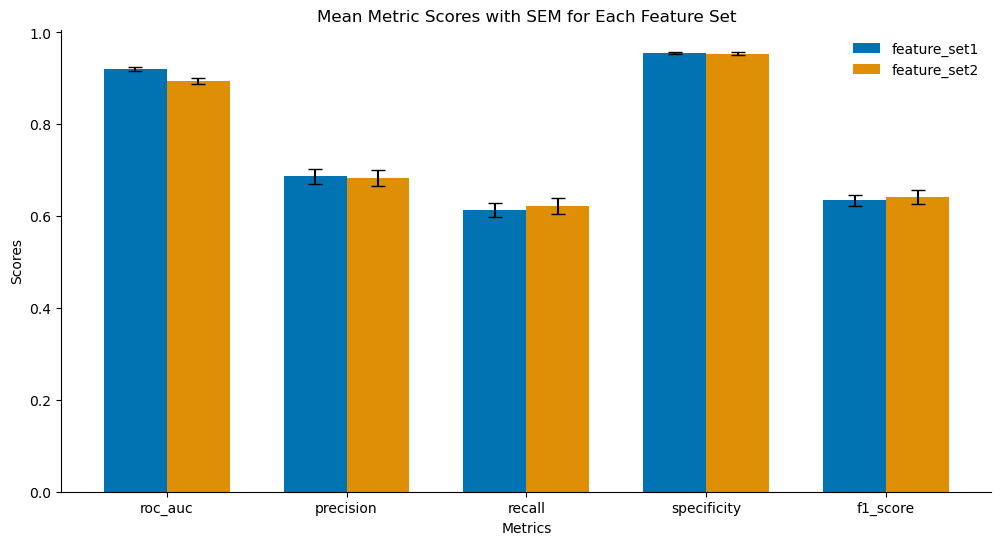

In [373]:
mean_metrics = {}
sem_metrics = {}

for feature_set, metrics in outputs.items():
    mean_metrics[feature_set] = {metric: np.mean(values) for metric, values in metrics.items()}
    sem_metrics[feature_set] = {metric: (np.std(values, ddof=1) / np.sqrt(len(values))) for metric, values in metrics.items()}

# Metrics to plot
metric_names = ['roc_auc', 'precision', 'recall', 'specificity', 'f1_score']
feature_set_names = list(mean_metrics.keys())
n_feature_sets = len(feature_set_names)
n_metrics = len(metric_names)

# Positioning the bars
bar_width = 0.35
index = np.arange(n_metrics)

# Set color palette
colors = sns.color_palette("colorblind", n_feature_sets)

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 6))

for i, feature_set in enumerate(feature_set_names):
    means = [mean_metrics[feature_set][metric] for metric in metric_names]
    sems = [sem_metrics[feature_set][metric] for metric in metric_names]
    ax.bar(index + i * bar_width, means, bar_width, yerr=sems, capsize=5, label=feature_set, color=colors[i])

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Mean Metric Scores with SEM for Each Feature Set')
ax.set_xticks(index + bar_width * (n_feature_sets - 1) / 2)
ax.set_xticklabels(metric_names)

# Style the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False)

# Show the plot
plt.show()

Ok, each planned image has now been generated - no point fussing about them until we sort out the underlying data stability.